In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [187]:
dati = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati = dati[['Date', 'Close']]
dati = dati.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'])
dati['Timestamp'] = dati['Timestamp'].dt.strftime('%Y-%m-%d')
dati['Timestamp'] = pd.to_datetime(dati['Timestamp'], format='%Y-%m-%d')
dati

,Timestamp,Price
0,2014-09-17,355.957367
1,2014-09-18,328.539368
2,2014-09-19,307.761139
3,2014-09-20,318.758972
4,2014-09-21,310.632446
...,...,...
3503,2024-04-20,59876.710938
3504,2024-04-21,60956.074219
3505,2024-04-22,60919.242188
3506,2024-04-23,62729.296875


In [188]:
data_inizio = '2021-02-01'
data_fine = '2021-07-01'
indice_inizio = dati[dati['Timestamp'] == data_inizio].index[0]
indice_fine = dati[dati['Timestamp'] == data_fine].index[0]
dati = dati[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price
0,2021-02-01,27790.582031
1,2021-02-02,29501.521484
2,2021-02-03,31119.447266
3,2021-02-04,30859.554688
4,2021-02-05,31658.248047
...,...,...
146,2021-06-27,29013.742188
147,2021-06-28,28866.302734
148,2021-06-29,30139.980469
149,2021-06-30,29555.054688


In [189]:
# Parametri di input
bitcoin_iniziali = 0.02478146   # Quantità iniziale di Bitcoin posseduti
liquidità_iniziale = 0  # Liquidità iniziale in euro
prezzo_medio_acquisti = 15000  # Prezzo medio ponderato degli acquisti
prezzo_medio_vendite = 20000   # Prezzo medio ponderato delle vendite
pct_paracadute = 0.05  # Percentuale di paracadute (ad es., 5%)
soglia_sopportabile = 0.3  # Percentuale di discesa sopportabile (es. 20%)
vendita_rispetto_inizio = True  # Se vendere rispetto ai BTC iniziali

# Calcola la base di riferimento per il prezzo (prezzo medio vendite + pct_paracadute)
base_di_riferimento = prezzo_medio_vendite * (1 + pct_paracadute)

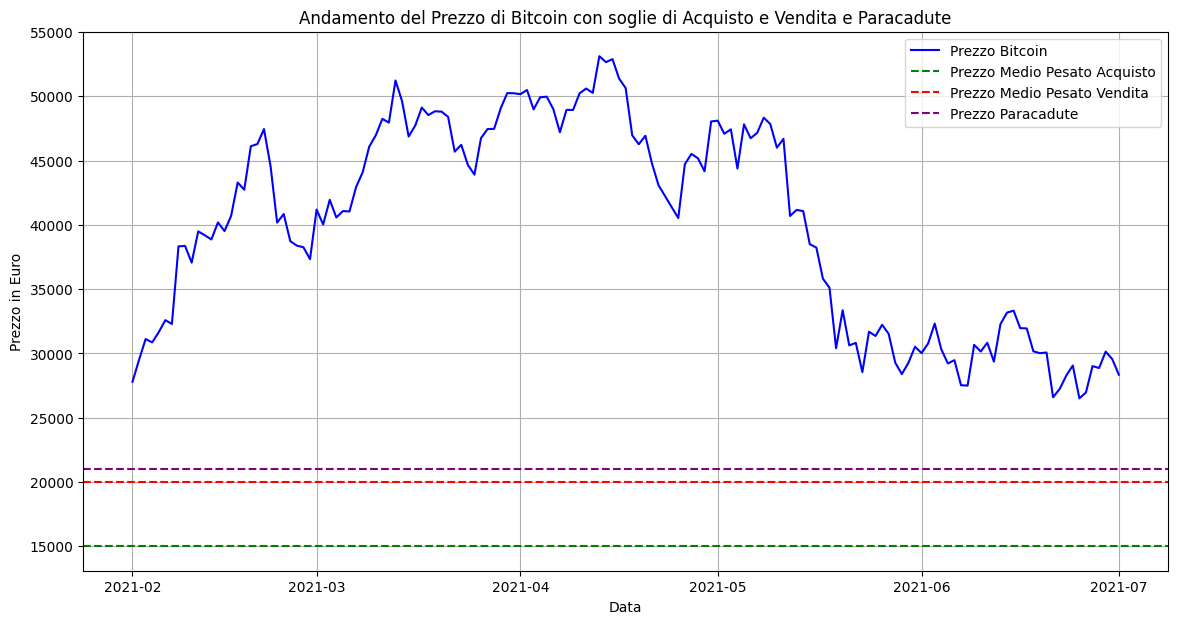

In [190]:
# Creazione del grafico
plt.figure(figsize=(14, 7))
plt.plot(dati["Timestamp"], dati["Price"], color="blue", label="Prezzo Bitcoin")

# Linea verde per il prezzo medio di acquisto
plt.axhline(y=prezzo_medio_acquisti, color="green", linestyle="--", linewidth=1.5, label="Prezzo Medio Pesato Acquisto")

# Linea rossa per il prezzo medio di vendita
plt.axhline(y=prezzo_medio_vendite, color="red", linestyle="--", linewidth=1.5, label="Prezzo Medio Pesato Vendita")

# Linea rossa per il prezzo medio di vendita
plt.axhline(y=base_di_riferimento, color="purple", linestyle="--", linewidth=1.5, label="Prezzo Paracadute")

# Dettagli del grafico
plt.title("Andamento del Prezzo di Bitcoin con soglie di Acquisto e Vendita e Paracadute")
plt.xlabel("Data")
plt.ylabel("Prezzo in Euro")
plt.legend()
plt.grid()

# Mostra il grafico
plt.show()

In [191]:
# Variabili iniziali
btc_posseduti = bitcoin_iniziali
liquidità = liquidità_iniziale
massimo_prezzo_raggiunto = dati['Price'].iloc[0]  # Per tenere traccia del massimo raggiunto

# DataFrame per registrare le transazioni giornaliere
transazioni = []

# Itera sulle righe del DataFrame (supponendo ordinato per data)
for i in range(1, len(dati)):
    # Aggiorna il massimo prezzo raggiunto
    prezzo_attuale = dati["Price"].iloc[i]
    massimo_prezzo_raggiunto = max(massimo_prezzo_raggiunto, prezzo_attuale)

    azione = "-"
    btc_da_vendere = 0
    liquidità_guadagnata = 0
    pct_btc_venduta_attuali = '-'
    pct_btc_venduta_iniziali = '-'

    # Calcola la percentuale attuale di discesa rispetto alla base di riferimento
    if massimo_prezzo_raggiunto > base_di_riferimento:
        percentuale_discesa_relativa = (massimo_prezzo_raggiunto - prezzo_attuale) / (massimo_prezzo_raggiunto - base_di_riferimento)
    else:
        percentuale_discesa_relativa = 0
    
    # Controlla se il prezzo attuale è in discesa rispetto al prezzo di ieri
    prezzo_ieri = dati["Price"].iloc[i - 1]
    prezzo_in_discesa = prezzo_attuale < prezzo_ieri
    variazione_prezzo = (prezzo_attuale - prezzo_ieri) / prezzo_ieri if prezzo_ieri > 0 else 0

    # Condizione di vendita
    if percentuale_discesa_relativa > soglia_sopportabile and prezzo_in_discesa:
        # Calcola la percentuale di BTC da vendere
        percentuale_da_vendere = percentuale_discesa_relativa if percentuale_discesa_relativa <= 1 else 1
        
        if vendita_rispetto_inizio:
            # Calcola la quantità di BTC da vendere rispetto ai BTC iniziali
            btc_da_vendere = bitcoin_iniziali * percentuale_da_vendere
        else:
            # Calcola la quantità di BTC da vendere rispetto ai BTC attualmente posseduti
            btc_da_vendere = btc_posseduti * percentuale_da_vendere

        # Verifica di non vendere più BTC di quanti ne possieda
        if btc_da_vendere > btc_posseduti:
            btc_da_vendere = btc_posseduti

        if btc_posseduti > 0:
            # Effettua la vendita
            liquidità_guadagnata = btc_da_vendere * prezzo_attuale
            liquidità += liquidità_guadagnata
            btc_posseduti_prima = btc_posseduti
            btc_posseduti -= btc_da_vendere
            azione = "Vendita"

            # Calcola le percentuali di BTC venduta
            pct_btc_venduta_attuali = (btc_da_vendere / btc_posseduti_prima)
            pct_btc_venduta_iniziali = (btc_da_vendere / bitcoin_iniziali)

    # Valore totale del portafoglio
    valore_totale_portafoglio = liquidità + (btc_posseduti * prezzo_attuale)

    # Registra i dati nel dataframe delle transazioni
    transazioni.append({
        "Timestamp": dati["Timestamp"].iloc[i],
        "prezzo": prezzo_attuale,
        "variazione % prezzo": variazione_prezzo,  # Convertito in percentuale
        "% discesa relativa": percentuale_discesa_relativa if prezzo_in_discesa else "-",
        "azione": azione,
        "quantità BTC venduta": btc_da_vendere,
        "% BTC venduta attuali": pct_btc_venduta_attuali,
        "% BTC venduta iniziali": pct_btc_venduta_iniziali,
        "liquidità guadagnata": liquidità_guadagnata,
        "liquidità": liquidità,
        "bitcoin": btc_posseduti,
        "valore_totale_portafoglio": valore_totale_portafoglio
    })

# Crea un DataFrame dalle transazioni
df_transazioni = pd.DataFrame(transazioni)

# Mostra le prime righe del DataFrame delle transazioni
df_transazioni

,Timestamp,prezzo,variazione % prezzo,% discesa relativa,azione,quantità BTC venduta,% BTC venduta attuali,% BTC venduta iniziali,liquidità guadagnata,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-02,29501.521484,0.061565,-,-,0.0,-,-,0.0,0.000000,0.024781,731.090775
1,2021-02-03,31119.447266,0.054842,-,-,0.0,-,-,0.0,0.000000,0.024781,771.185338
2,2021-02-04,30859.554688,-0.008351,0.025682,-,0.0,-,-,0.0,0.000000,0.024781,764.744820
3,2021-02-05,31658.248047,0.025882,-,-,0.0,-,-,0.0,0.000000,0.024781,784.537608
4,2021-02-06,32588.472656,0.029383,-,-,0.0,-,-,0.0,0.000000,0.024781,807.589932
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-06-27,29013.742188,0.075958,-,-,0.0,-,-,0.0,953.093882,0.000000,953.093882
146,2021-06-28,28866.302734,-0.005082,0.755124,-,0.0,-,-,0.0,953.093882,0.000000,953.093882
147,2021-06-29,30139.980469,0.044123,-,-,0.0,-,-,0.0,953.093882,0.000000,953.093882
148,2021-06-30,29555.054688,-0.019407,0.733683,-,0.0,-,-,0.0,953.093882,0.000000,953.093882


In [192]:
df_transazioni['valore_totale_portafoglio'].iloc[-1] / df_transazioni['valore_totale_portafoglio'].iloc[0]

np.float64(1.303660112604986)

In [193]:
df_transazioni[:50]

,Timestamp,prezzo,variazione % prezzo,% discesa relativa,azione,quantità BTC venduta,% BTC venduta attuali,% BTC venduta iniziali,liquidità guadagnata,liquidità,bitcoin,valore_totale_portafoglio
0,2021-02-02,29501.521484,0.061565,-,-,0.000000,-,-,0.000000,0.000000,0.024781,731.090775
1,2021-02-03,31119.447266,0.054842,-,-,0.000000,-,-,0.000000,0.000000,0.024781,771.185338
2,2021-02-04,30859.554688,-0.008351,0.025682,-,0.000000,-,-,0.000000,0.000000,0.024781,764.744820
3,2021-02-05,31658.248047,0.025882,-,-,0.000000,-,-,0.000000,0.000000,0.024781,784.537608
4,2021-02-06,32588.472656,0.029383,-,-,0.000000,-,-,0.000000,0.000000,0.024781,807.589932
5,2021-02-07,32288.650391,-0.009200,0.025872,-,0.000000,-,-,0.000000,0.000000,0.024781,800.159898
6,2021-02-08,38329.667969,0.187094,-,-,0.000000,-,-,0.000000,0.000000,0.024781,949.865134
7,2021-02-09,38362.296875,0.000851,-,-,0.000000,-,-,0.000000,0.000000,0.024781,950.673726
8,2021-02-10,37065.046875,-0.033816,0.074716,-,0.000000,-,-,0.000000,0.000000,0.024781,918.525977
9,2021-02-11,39494.441406,0.065544,-,-,0.000000,-,-,0.000000,0.000000,0.024781,978.729920


In [194]:
# Supponiamo che df_transazioni sia già creato e contenga tutte le colonne richieste
# Se ci sono NaN, conviene sistemarli per evitare problemi
df_transazioni['quantità BTC venduta'] = pd.to_numeric(df_transazioni['quantità BTC venduta'], errors='coerce')

# Filtro solo le transazioni di vendita
vendite = df_transazioni[df_transazioni['azione'] == 'Vendita']

# Calcolo della dimensione dei punti per le vendite
max_quantita_vendita = vendite['quantità BTC venduta'].max()

def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Applica la funzione di dimensione per ogni punto vendita
dimensioni_vendite = vendite['quantità BTC venduta'].apply(lambda x: calcola_dimensione(x, max_quantita_vendita))

# Funzione per formattare in modo sicuro i prezzi e altri valori
def safe_format(value, precision=2):
    return f"{value:.{precision}f}" if pd.notna(value) else "None"

# Creazione del grafico dei prezzi con le vendite
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=df_transazioni['Timestamp'],
    y=df_transazioni['prezzo'],
    mode='lines',
    name='Prezzi Bitcoin',
    line=dict(color='blue', width=2),
    hoverinfo='x+y'
))

# Scatter plot per le vendite con dimensione in base alla quantità BTC venduta
fig.add_trace(go.Scatter(
    x=vendite['Timestamp'],
    y=vendite['prezzo'],
    mode='markers',
    name='Vendite',
    marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {safe_format(prezzo)} €<br>Variazione % prezzo: {safe_format(var_prezzo * 100, 2)} %<br>% discesa relativa: {round(desc * 100, 2) or 'None'} %<br>Quantità BTC venduta: {safe_format(qta, 4)}<br>% BTC venduta attuali: {safe_format(pct_attuali * 100, 2)} %<br>% BTC venduta iniziali: {safe_format(pct_iniziali * 100, 2)} %<br>Liquidità guadagnata: {safe_format(liquid_guad, 2)} €<br>Liquidità totale: {safe_format(liquid_tot, 2)} €<br>BTC rimanenti: {safe_format(btc_posseduti, 4)}<br>Valore totale portafoglio: {safe_format(valore_port, 2)} €"
        for timestamp, prezzo, var_prezzo, desc, qta, pct_attuali, pct_iniziali, liquid_guad, liquid_tot, btc_posseduti, valore_port in zip(
            vendite['Timestamp'],
            vendite['prezzo'],
            vendite['variazione % prezzo'],
            vendite['% discesa relativa'],
            vendite['quantità BTC venduta'],
            vendite['% BTC venduta attuali'],
            vendite['% BTC venduta iniziali'],
            vendite['liquidità guadagnata'],
            vendite['liquidità'],
            vendite['bitcoin'],
            vendite['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Aggiunta delle linee orizzontali
fig.add_hline(y=prezzo_medio_acquisti, line=dict(color='green', width=2, dash='dash'), name='Prezzo Medio Acquisto')
fig.add_hline(y=prezzo_medio_vendite, line=dict(color='red', width=2, dash='dash'), name='Prezzo Medio Vendita')
fig.add_hline(y=base_di_riferimento, line=dict(color='purple', width=2, dash='dash'), name='Base di Riferimento')

# Configurazione del layout con range slider sull'asse X
fig.update_layout(
    title='Andamento Prezzi Bitcoin e Transazioni di Vendita',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1200,
    height=800,
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico interattivo
fig.show()